In [98]:
%%capture
#%matplotlib inline
%matplotlib notebook

%load_ext autoreload
%autoreload 2

%reset -f

import os, sys, copy
import numpy as np

import pylab as plt
import matplotlib as mpl
import scipy.io

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams.update({"axes.grid" : True})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

plt.rcParams.update({'font.size': 14})

In [99]:
from twpazer import vnautils

In [100]:
res=dict()

# Gain at $T = 3\, K$

In [101]:
pathname = '/home/giachero/gsbox/kids_rd/DARTWARS/data/KIT.v3/'
filename = '20240607_124743_gain_profile_pump_pow_sweep_3K.mat'

mat=scipy.io.loadmat(os.path.join(pathname, filename))
pows=mat['pumpPows'][0]

/home/giachero/pvenv/dwenv3.10/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


<IPython.core.display.Javascript object>


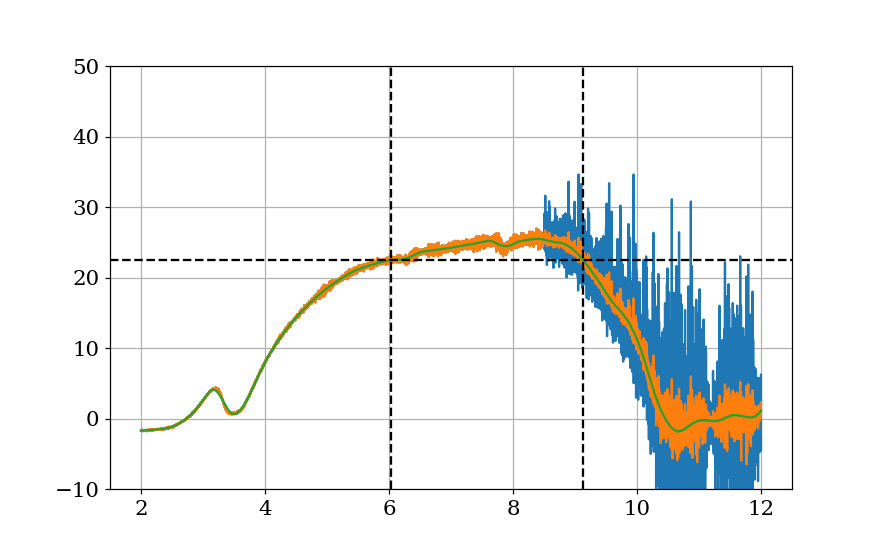

[3.094]


In [102]:
f    = mat['f'] 
data = mat['gainAll'][11,:]

plt.figure()
plt.plot(f,data)

#factor = vnautils.get_compensation_factor(f, data, 8.5, 0.5)
f, newdata, smoothed = vnautils.compensate_data(f, data, 8.5, 0.5)
plt.plot(f,newdata)
plt.plot(f, smoothed)

plt.ylim([-10, 50])
f1, f2 = vnautils.get_bandwidth(f, smoothed,3)

#plt.plot(f, thisdata)

plt.axhline(y=np.max(smoothed)-3, color='k', linestyle='--')
plt.axvline(x=f1, color='k', linestyle='--')
plt.axvline(x=f2, color='k', linestyle='--')
print(f2-f1)


In [103]:
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

from matplotlib import cm, colors
cmap   = plt.cm.turbo_r
cols   = get_colors(pows, cmap, 
                    vmin=np.min(pows), vmax=np.max(pows))
cols   = list(reversed(cols))

#cols   = dict(zip(reversed(pows), cols))

<IPython.core.display.Javascript object>


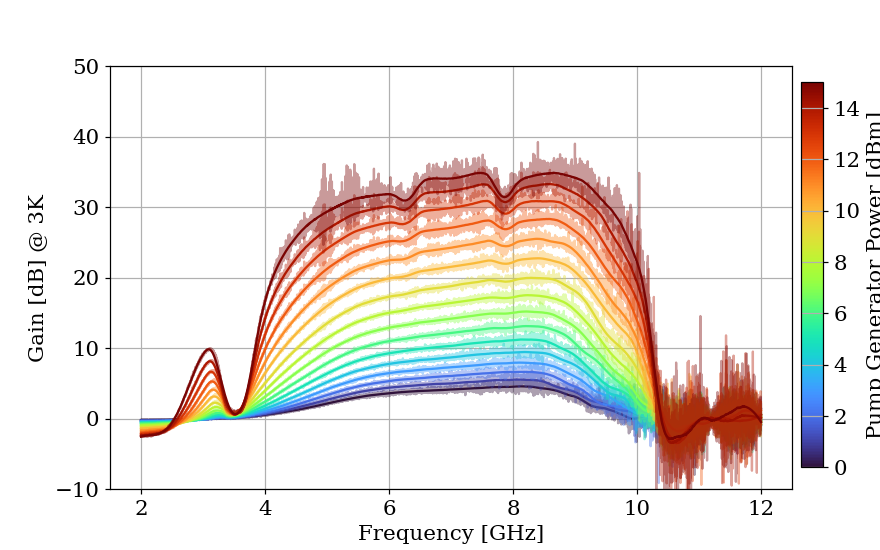

In [104]:
T=3000

res.setdefault(T, dict())

res[T].setdefault('f'      , mat['f'])
res[T].setdefault('gain'   , copy.deepcopy(mat['gainAll']))
res[T].setdefault('gain_s' , copy.deepcopy(mat['gainAll']))
res[T].setdefault('ripple' , list())
res[T].setdefault('maxgain', list())
res[T].setdefault('pow'    , list())

fig=plt.figure()

gains=list()
ripples = list()
for i in range(mat['gainSmoothedAll'].shape[0]):
        
    f, G, Gs = vnautils.compensate_data(res[T]['f'], res[T]['gain'][i,:], 8.5, 0.5)
    rstd, rmm = vnautils.estimate_ripple(f, G, 7, 0.5)
    
    res[T]['maxgain'].append(np.max(Gs))
    res[T]['ripple'].append(rstd)        
    res[T]['pow'].append(pows[i])
    res[T]['gain'][i,:]=G
    res[T]['gain_s'][i,:]=Gs
        
    plt.plot(f, G, alpha=0.4, color=cols[i])
    plt.plot(f, Gs, color=plt.gca().lines[-1].get_color())
    
 
plt.ylim([-10, 50]) 
plt.xlabel('Frequency [GHz]')
plt.ylabel('Gain [dB] @ 3K')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.025, 0.7])
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(np.min(pows),                                                 
                                                     np.max(pows)), cmap=cmap.reversed()), cax=cbar_ax)
    
cbar_ax.set_ylabel('Pump Generator Power [dBm]')

for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(pathname,'global_gain_T3K'+e),
                      bbox_inches='tight', transparent=True)

<IPython.core.display.Javascript object>


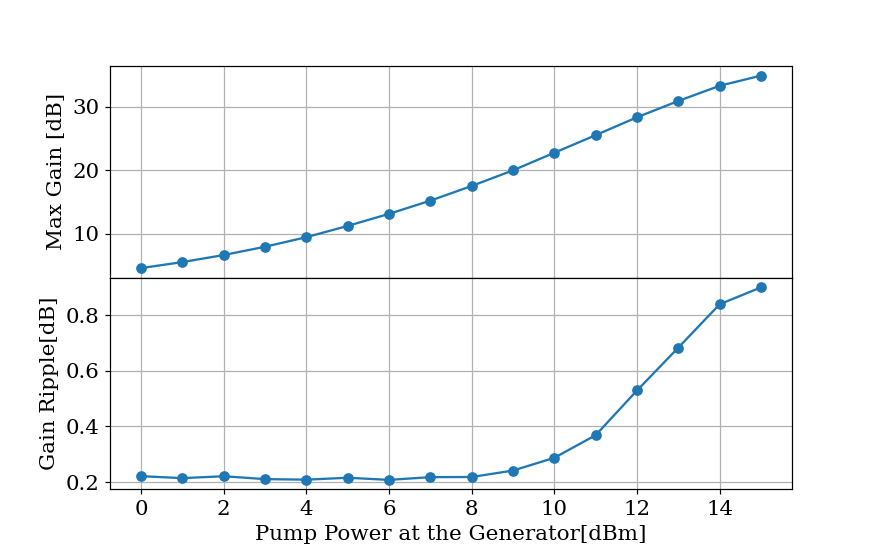

In [105]:
fig, ax = plt.subplots(2,1)
plt.subplots_adjust(wspace=0, hspace=0)

ax[0].plot(res[T]['pow'], res[T]['maxgain'], marker='o')
ax[0].set_xlabel('Pump Generator Power [dBm]')
ax[0].set_ylabel('Max Gain [dB]')

ax[1].plot(res[T]['pow'], res[T]['ripple'],marker='o')
ax[1].set_xlabel('Pump Power at the Generator[dBm]')
ax[1].set_ylabel('Gain Ripple[dB]')


for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(pathname,'global_trend_3K'+e),
                      bbox_inches='tight', transparent=True)

# Gain at $T = 50\, mK$

In [106]:
pathname = '/home/giachero/gsbox/kids_rd/DARTWARS/data/KIT.v3/'
filename = '20240717_112545_gain_profile_pump_pow_sweep_50mK.mat'

mat=scipy.io.loadmat(os.path.join(pathname, filename))

power_offset = 32
pows=mat['pumpPows'][0]-power_offset

/home/giachero/pvenv/dwenv3.10/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


<IPython.core.display.Javascript object>


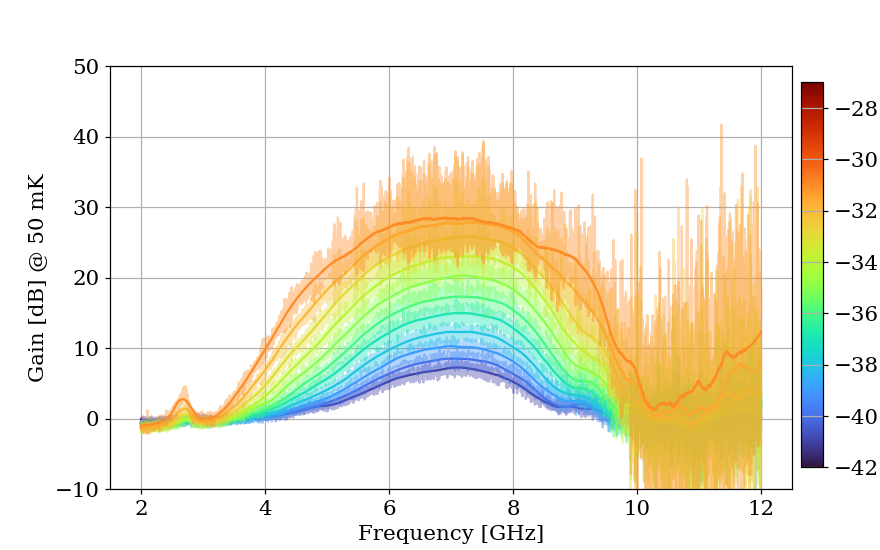

0
12
13
14
15


In [107]:
T=50

if T in res: 
    del res[T]

res.setdefault(T, dict())

res[T].setdefault('f'      , mat['f'])
res[T].setdefault('gain'   , copy.deepcopy(mat['gainAll']))
res[T].setdefault('gain_s' , copy.deepcopy(mat['gainAll']))
res[T].setdefault('ripple' , list())
res[T].setdefault('maxgain', list())
res[T].setdefault('pow'    , list())

fig=plt.figure()

gains=list()
ripples = list()

excluded=[0, 12, 13, 14, 15]
for i in range(mat['gainSmoothedAll'].shape[0]):
        
    if i in excluded:
        print(i)
        continue
    
    f, G, Gs = vnautils.compensate_data(res[T]['f'], res[T]['gain'][i,:], 8.5, 0.5)
    rstd, rmm = vnautils.estimate_ripple(f, G, 7, 0.5)
    
    res[T]['maxgain'].append(np.max(Gs))
    res[T]['ripple'].append(rstd)        
    res[T]['pow'].append(pows[i])
    res[T]['gain'][i,:]=G
    res[T]['gain_s'][i,:]=Gs
        
    plt.plot(f, G, alpha=0.4, color=cols[i])
    plt.plot(f, Gs, color=plt.gca().lines[-1].get_color())
    
    
 
plt.ylim([-10, 50]) 
plt.xlabel('Frequency [GHz]')
plt.ylabel('Gain [dB] @ 50 mK')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.025, 0.7])
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(np.min(pows),                                                 
                                                     np.max(pows)), cmap=cmap.reversed()), cax=cbar_ax)
    
cbar_ax.set_ylabel('Pump Generator Power [dBm]')

for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(pathname,'global_gain_T3K'+e),
                      bbox_inches='tight', transparent=True)

<IPython.core.display.Javascript object>


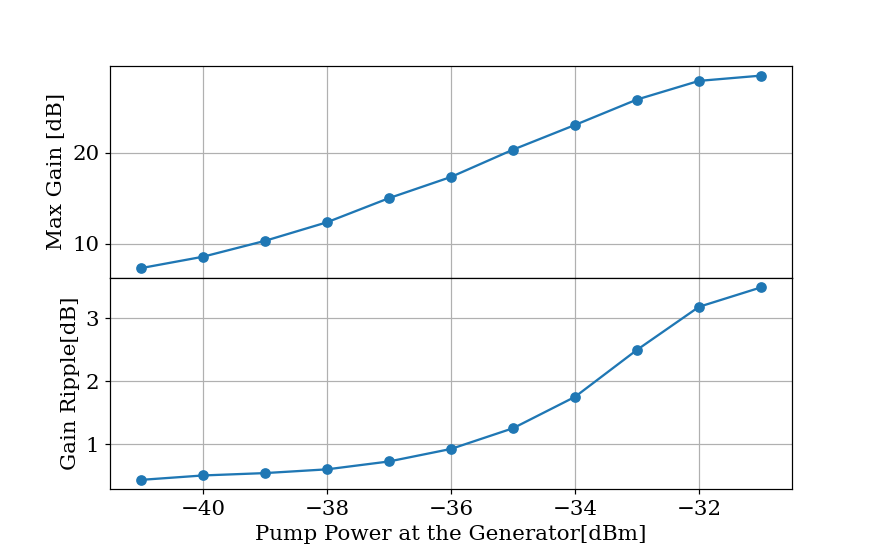

In [108]:
fig, ax = plt.subplots(2,1)
plt.subplots_adjust(wspace=0, hspace=0)

ax[0].plot(res[T]['pow'], res[T]['maxgain'], marker='o')
ax[0].set_xlabel('Pump Generator Power [dBm]')
ax[0].set_ylabel('Max Gain [dB]')

ax[1].plot(res[T]['pow'], res[T]['ripple'],marker='o')
ax[1].set_xlabel('Pump Power at the Generator[dBm]')
ax[1].set_ylabel('Gain Ripple[dB]')


for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(pathname,'global_trend_50mK'+e),
                      bbox_inches='tight', transparent=True)

<IPython.core.display.Javascript object>


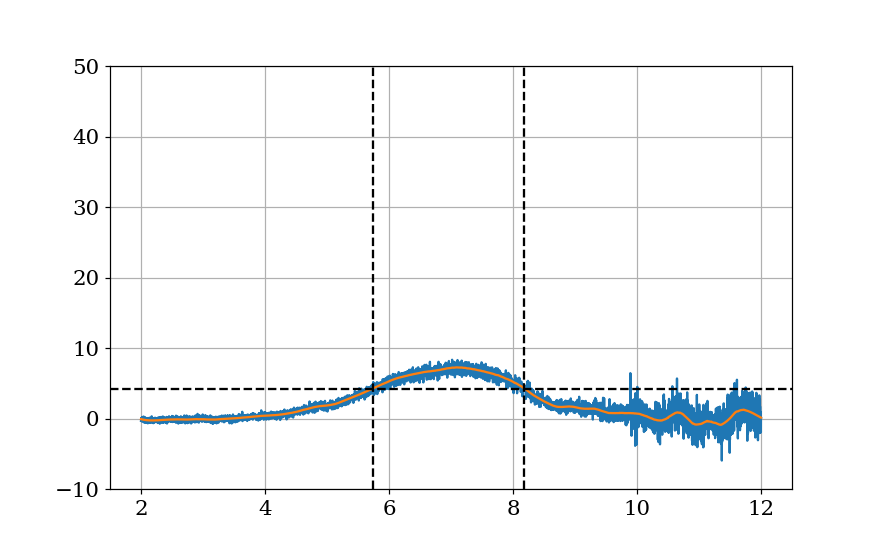

1.1428999335323045
[2.446]


In [109]:
f    = res[T]['f'] 
data = res[T]['gain'][1,:]

plt.figure()
#plt.plot(f,data)

factor = vnautils.get_compensation_factor(f, data, 8.5, 0.5)
print(factor)
f, newdata, smoothed = vnautils.compensate_data(f, data, 8.5, 0.5)
plt.plot(f,newdata)
plt.plot(f, smoothed)

plt.ylim([-10, 50])
f1, f2 = vnautils.get_bandwidth(f, smoothed,3)

#plt.plot(f, thisdata)

plt.axhline(y=np.max(smoothed)-3, color='k', linestyle='--')
plt.axvline(x=f1, color='k', linestyle='--')
plt.axvline(x=f2, color='k', linestyle='--')
print(f2-f1)

In [ ]:
res

In [113]:
def get_data(matfile, poffset=-32, excluded=None):
    
    mat=scipy.io.loadmat(matfile)
    #pows=
    
    
    G      = np.array([])
    Gs     = np.array([])
    pows   = list()
    maxG   = list()
    ripple = list() 
    BW     = list()
    
    for i in range(mat['gainAll'].shape[0]):    
        if excluded and i in excluded:
            continue
        
        f, Gtemp, Gstemp = vnautils.compensate_data(mat['f'], mat['gainAll'][i,:], 8.5, 0.5)
          
        if G.size:
            G  = np.vstack((G, Gtemp))
            Gs = np.vstack((Gs,Gstemp))  
        else:
            G  = Gtemp
            Gs = Gstemp
        
        pows.append(mat['pumpPows'][0][i]+poffset)
        maxG.append(np.max(Gstemp))
        rstd, rmm = vnautils.estimate_ripple(f, Gtemp, 7, 0.5)
        ripple.append(rmm)
        
        f1, f2 = vnautils.get_bandwidth(f, Gstemp, 3)
        BW.append(f2-f1)
        
    return {'f'     : np.array(mat['f']),
            'G'     : np.array(G),           
            'Gs'    : np.array(Gs),
            'pows'  : np.array(pows), 
            'maxG'  : maxG, 
            'ripple': ripple, 
            'BW'    : BW}

In [133]:
from matplotlib import cm, colors
import matplotlib.gridspec as gridspec  

def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))


def plot_trend(T, res, pathname=None):
    
    if T not in res:
        return

    cmap   = plt.cm.turbo_r
    cols   = get_colors(res[T]['pows'], 
                        cmap, 
                        vmin=np.min(res[T]['pows']), 
                        vmax=np.max(res[T]['pows']))
    cols   = list(reversed(cols))

        
    fig=plt.figure()
    #plt.subplots_adjust(wspace=0, hspace=0)
    size = plt.gcf().get_size_inches()#*plt.gcf().dpi
    plt.gcf().set_figheight(size[1]*2.2)
    plt.gcf().set_figwidth(size[0])
  
    gs = gridspec.GridSpec(2, 1,  hspace=0.3)

    ax0 = plt.subplot(gs[0])
    
    for i in range(len(res[T]['pows'])):
        
        ax0.plot(res[T]['f'], res[T]['G'][i,:],  alpha=0.4, color=cols[i])
        ax0.plot(res[T]['f'], res[T]['Gs'][i,:], color=ax0.lines[-1].get_color(), zorder=1000)
    
    
    ax0.set_ylim([-10, 50]) 
    ax0.set_xlabel('Frequency [GHz]')
    ax0.set_ylabel('Gain [dB]')

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.53, 0.025, 0.35])
    fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(np.min(res[T]['pows']),                                                                                                     
                                                         np.max(res[T]['pows'])), 
                                   cmap=cmap.reversed()), 
                 cax=cbar_ax, 
                 ax=ax0)
    
    cbar_ax.set_ylabel('Pump Generator Power [dBm]')
    
    
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,    
                                             subplot_spec=gs[1], 
                                             wspace=0, hspace=0)
    
    axi0 = plt.Subplot(fig, inner[0])
    
    axi0.plot(res[T]['pows'], res[T]['maxG'], marker='o')
    #axi0.set_xlabel('Pump Generator Power [dBm]')
    axi0.xaxis.set_ticklabels([])
    axi0.set_ylabel('Max Gain\n[dB]')
    
    fig.add_subplot(axi0)
    
    axi1 = plt.Subplot(fig, inner[1])
     
    axi1.plot(res[T]['pows'], res[T]['ripple'], marker='o')
    #axi1.set_xlabel('Pump Generator Power [dBm]')
    axi1.xaxis.set_ticklabels([])
    axi1.set_ylabel('Ripple\n[dB]')
    
    fig.add_subplot(axi1)
    
    
    axi2 = plt.Subplot(fig, inner[2])
     
    axi2.plot(res[T]['pows'], res[T]['BW'], marker='o')
    axi2.set_xlabel('Pump Generator Power [dBm]')
    axi2.set_ylabel('BW\n[GHz]')
    
    fig.add_subplot(axi2)
    

    if pathname and type(pathname) == str:
        for e in ['.pdf', '.svg']:
            plt.gcf().savefig(os.path.join(pathname,'global_gain_{T}mk'.format(T=T)+e),            
                              bbox_inches='tight', transparent=True)
    
    return

/home/giachero/pvenv/dwenv3.10/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


2.830200241729008
3.292889249882414
3.730241407166517
3.736253023233713
4.268825179236055
5.673196610509757
6.980678589526086
9.023267396109894
13.309230500186803
15.586276094970241
16.95427355110116


<IPython.core.display.Javascript object>


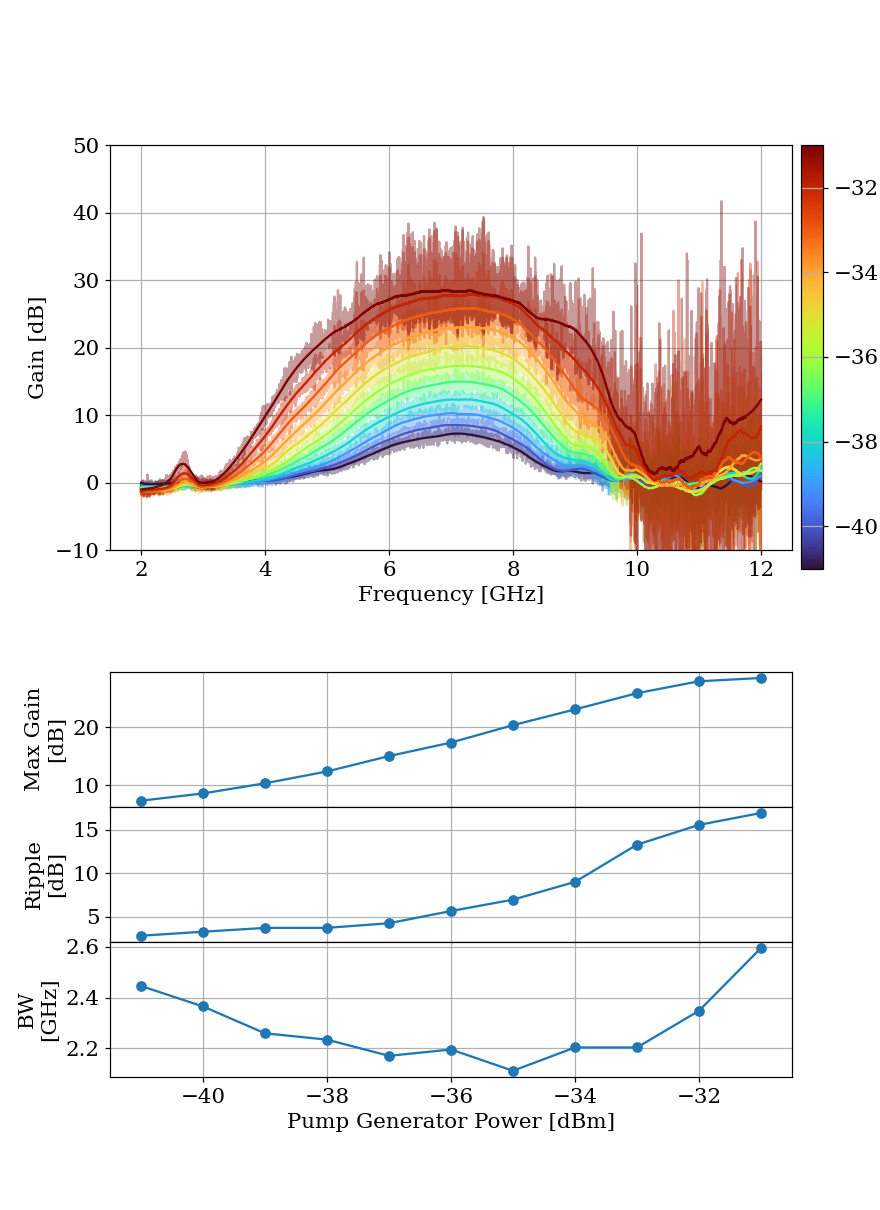

In [134]:
pathname = '/home/giachero/gsbox/kids_rd/DARTWARS/data/KIT.v3/'
filename = '20240717_112545_gain_profile_pump_pow_sweep_50mK.mat'


res2={50: get_data(os.path.join(pathname, filename), excluded=[0,12,13,14,15])}

plot_trend(50, res2, pathname)

In [122]:
res2[50]['pows'].shape

(11,)

In [ ]:
res2[50]['G'].shape